In [78]:
import os
import subprocess
from pathlib import Path
import torch
from mmdet3d.evaluation.metrics import nuscenes_metric as nus_metric
from mmdet3d.evaluation.metrics.nuscenes_metric import output_to_nusc_box
import json 
from pyquaternion import Quaternion
from nuscenes.utils.data_classes import Box
from nuscenes.utils.geometry_utils import transform_matrix
import operator
from functools import reduce
from pathlib import Path
import numpy as np
from nuscenes.nuscenes import NuScenes
from nuscenes.eval.detection.config import config_factory
from nuscenes.eval.detection.evaluate import NuScenesEval
from nuscenes.utils.data_classes import RadarPointCloud
from classes import cls_attr_dist, class_names, mini_val_tokens

In [79]:
DETECTION_THRESHOLD = 0.6

backend_args = None
home_dir = str(Path.home())
# nusc = NuScenes(version='v1.0-trainval', dataroot = f"{home_dir}/software/mmdetection3d/data/nuscenes")
nusc = NuScenes(version='v1.0-mini', dataroot = f"{home_dir}/software/mmdetection3d/data/nuscenes-mini")
dataroot = f"{home_dir}/software/mmdetection3d/data/nuscenes-mini/"
out_dir = f"{home_dir}/nuscenes_dataset/inference_results_mini"
preds_dir = os.path.join(out_dir, "model2_good/preds")
ann_file=dataroot + 'nuscenes_infos_val.pkl'
metric='bbox'

pcd_path = f"{home_dir}/software/mmdetection3d/data/nuscenes-mini/samples/LIDAR_TOP/"
mmdet_path = f"{home_dir}/software/mmdetection3d"
pcd_list = os.listdir(pcd_path)

# Config and model:
# configs_path = "configs/pointpillars/hv_pointpillars_fpn_sbn-all_4x8_2x_nus-3d.py"
# checkpoint_path = "checkpoints/hv_pointpillars_fpn_sbn-all_4x8_2x_nus-3d_20210826_104936-fca299c1.pth"

# Instantiate evaluator:
evaluator = nus_metric.NuScenesMetric(dataroot, ann_file)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.486 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


|Checkpoint.pth|config acc to links|log.json|config.py acc to log.json
|------------|----------|---|---|
|hv_pointpillars_secfpn_sbn-all_4x8_2x_nus-3d_20210826_225857-f19d00a3.pth|pointpillars_hv_secfpn_sbn-all_8xb4-2x_nus-3d.py|hv_pointpillars_secfpn_sbn-all_4x8_2x_nus-3d_20210826_225857.log.json|hv_pointpillars_secfpn_sbn-all_4x8_2x_nus-3d.py|
|hv_pointpillars_secfpn_sbn-all_fp16_2x8_2x_nus-3d_20201020_222626-c3f0483e.pth|pointpillars_hv_secfpn_sbn-all_8xb2-amp-2x_nus-3d.py|hv_pointpillars_secfpn_sbn-all_fp16_2x8_2x_nus-3d_20201020_222626.log.json||
|hv_pointpillars_fpn_sbn-all_4x8_2x_nus-3d_20210826_104936-fca299c1.pth|pointpillars_hv_fpn_sbn-all_8xb4-2x_nus-3d.py|hv_pointpillars_fpn_sbn-all_4x8_2x_nus-3d_20210826_104936.log.json|hv_pointpillars_fpn_sbn-all_4x8_2x_nus-3d.py|
|hv_pointpillars_fpn_sbn-all_fp16_2x8_2x_nus-3d_20201021_120719-269f9dd6.pth|pointpillars_hv_fpn_sbn-all_8xb2-amp-2x_nus-3d.py|hv_pointpillars_fpn_sbn-all_fp16_2x8_2x_nus-3d_20201021_120719.log.json||


In [80]:
# Modified PCDet functions:
# Box conversion
def boxes_lidar_to_nusenes(det_info):
    boxes3d = det_info['bboxes_3d']
    scores = det_info['scores_3d']
    labels = det_info['labels_3d']

    box_list = []
    for k in range(boxes3d.shape[0]):
        quat = Quaternion(axis=[0, 0, 1], radians=boxes3d[k, 6])
        velocity = (*boxes3d[k, 7:9], 0.0) if boxes3d.shape[1] == 9 else (0.0, 0.0, 0.0)
        box = Box(
            boxes3d[k, :3],
            boxes3d[k, [4, 3, 5]],  # wlh
            quat, label=labels[k], score=scores[k], velocity=velocity,
        )
        box_list.append(box)
    return box_list

def lidar_nusc_box_to_global(nusc, boxes, sample_token):
    s_record = nusc.get('sample', sample_token)
    sample_data_token = s_record['data']['LIDAR_TOP']

    sd_record = nusc.get('sample_data', sample_data_token)
    cs_record = nusc.get('calibrated_sensor', sd_record['calibrated_sensor_token'])
    sensor_record = nusc.get('sensor', cs_record['sensor_token'])
    pose_record = nusc.get('ego_pose', sd_record['ego_pose_token'])

    data_path = nusc.get_sample_data_path(sample_data_token)
    box_list = []
    for box in boxes:
        # Move box to ego vehicle coord system
        box.rotate(Quaternion(cs_record['rotation']))
        box.translate(np.array(cs_record['translation']))
        # Move box to global coord system
        box.rotate(Quaternion(pose_record['rotation']))
        box.translate(np.array(pose_record['translation']))
        box_list.append(box)
    return box_list

def transform_det_annos_to_nusc_annos(det_annos, nusc):
    nusc_annos = {
        'results': {},
        'meta': None,
    }

    for det in det_annos:
        annos = []
        try:
            box_list = boxes_lidar_to_nusenes(det)
            box_list = lidar_nusc_box_to_global(
                nusc=nusc, boxes=box_list, sample_token=det['metadata']['token']
            )
        except:
            print("TypeError in transform_det_annos_to_nusc_annos: string indices must be integers")
        for k, box in enumerate(box_list):
            name = det['name'][k]
            if np.sqrt(box.velocity[0] ** 2 + box.velocity[1] ** 2) > 0.2:
                if name in ['car', 'construction_vehicle', 'bus', 'truck', 'trailer']:
                    attr = 'vehicle.moving'
                elif name in ['bicycle', 'motorcycle']:
                    attr = 'cycle.with_rider'
                else:
                    attr = None
            else:
                if name in ['pedestrian']:
                    attr = 'pedestrian.standing'
                elif name in ['bus']:
                    attr = 'vehicle.stopped'
                else:
                    attr = None
            attr = attr if attr is not None else max(
                cls_attr_dist[name].items(), key=operator.itemgetter(1))[0]
            nusc_anno = {
                'sample_token': det['metadata']['token'],
                'translation': box.center.tolist(),
                'size': box.wlh.tolist(),
                'rotation': box.orientation.elements.tolist(),
                'velocity': box.velocity[:2].tolist(),
                'detection_name': name,
                'detection_score': box.score,
                'attribute_name': attr
            }
            if det['scores_3d'][k] >= DETECTION_THRESHOLD:
                annos.append(nusc_anno)

        nusc_annos['results'].update({det["metadata"]["token"]: annos})

    return nusc_annos


In [81]:
def construct_token_dict():
    """
    Constructs a dictionary mapping filenames to lidar and sample tokens
    """
    token_dict = dict()
    for scene in nusc.scene:
        sample_token = scene['first_sample_token']
        sample = nusc.get('sample', sample_token)
        lidar_data = nusc.get('sample_data', sample['data']["LIDAR_TOP"])
        while sample['next'] != "":
            filename = lidar_data['filename']
            file_str = filename[filename.rfind("/")+1:].replace("bin", "json")
            token_dict[file_str] = {"lidar_token": lidar_data['token'], "sample_token": lidar_data['sample_token']}
            sample = nusc.get("sample", sample['next'])
            lidar_data = nusc.get('sample_data', sample['data']["LIDAR_TOP"])
        
        filename = lidar_data['filename']
        file_str = filename[filename.rfind("/")+1:].replace("bin", "json")
        token_dict[file_str] = {"lidar_token": lidar_data['token'], "sample_token": lidar_data['sample_token']}

    with open("token_dict_mini.json", 'w') as f:
        json.dump(token_dict, f)
    f.close()

In [82]:
def get_sample_token(fn):
    with open("token_dict_mini.json", 'r') as f:
        token_dict = json.load(f)
    sample_token = token_dict[fn]['sample_token']
    f.close()
    return sample_token

# Read json file:
def read_preds_file(fn):
    full_fn = os.path.join(preds_dir, fn)
    with open(full_fn, 'r') as f:
        result = json.load(f)
        result['bboxes_3d'] = torch.Tensor(result['bboxes_3d']).numpy()
        result['scores_3d'] = torch.Tensor(result['scores_3d']).numpy()
        class_labels = [class_names[k] for k in result['labels_3d']]
        result['labels_3d'] = torch.Tensor(result['labels_3d']).numpy()
        sample_token = dict()
        sample_token['token'] = get_sample_token(fn)
        result.update({'metadata':sample_token})
        result.update({'name':class_labels})
        
    f.close()
    return result

def read_results():
    """
    Reads the results from prediction files.

    Returns:
        list: A list of dictionaries containing the processed prediction data.
    """
    preds_fn = os.listdir(preds_dir)
    results = []
    count = 1
    for fn in preds_fn:
        if count%1000 == 0:
            print("Read results count: ", str(count))
        results.append(read_preds_file(fn))
        count += 1
    return results

def custom_result(fn):
    results = [read_preds_file(fn)]
    return results


In [83]:
def save_nusc_results(det_annos, **kwargs):
    nusc_annos = transform_det_annos_to_nusc_annos(det_annos, nusc)
    nusc_annos['meta'] = {
        'use_camera': False,
        'use_lidar': True,
        'use_radar': False,
        'use_map': False,
        'use_external': False,
    }

    output_path = Path(kwargs['output_path'])
    output_path.mkdir(exist_ok=True, parents=True)
    res_path = str(output_path / 'results_nusc.json')
    with open(res_path, 'w') as f:
        json.dump(nusc_annos, f)
    
    print('The predictions of NuScenes have been saved to {res_path}')
    return output_path, res_path

def get_metrics(output_path, res_path):
    eval_set_map = {
        'v1.0-mini': 'mini_val',
        'v1.0-trainval': 'val',
        'v1.0-test': 'test'
    }
    try:
        eval_version = 'detection_cvpr_2019'
        eval_config = config_factory(eval_version)
    except:
        eval_version = 'cvpr_2019'
        eval_config = config_factory(eval_version)

    nusc_eval = NuScenesEval(
        nusc,
        config=eval_config,
        result_path=res_path,
        eval_set=eval_set_map['v1.0-mini'],
        output_dir=str(output_path),
        verbose=True,
    )
    metrics_summary = nusc_eval.main(plot_examples=0, render_curves=False)

    with open(output_path / 'metrics_summary.json', 'r') as f:
        metrics = json.load(f)
    return metrics, metrics_summary, nusc_eval

In [84]:
def filter_results(results):
    return [
        result
        for result in results
        if result['metadata']['token'] in mini_val_tokens
    ]

In [85]:
construct_token_dict()
results = read_results()
results = filter_results(results)
nusc_results = transform_det_annos_to_nusc_annos(results, nusc)

FileNotFoundError: [Errno 2] No such file or directory: '/home/apurvabadithela/nuscenes_dataset/inference_results_mini/preds_old_bad_model'

In [86]:
print(len(nusc_results['results']))
output_path, res_path = save_nusc_results(results, output_path="/home/ranai/nuscenes_dataset/3D_Detection")
metrics, metrics_summary, obj = get_metrics(output_path, res_path)

81
The predictions of NuScenes have been saved to {res_path}
Initializing nuScenes detection evaluation
Loaded results from /home/ranai/nuscenes_dataset/3D_Detection/results_nusc.json. Found detections for 81 samples.
Loading annotations for mini_val split from nuScenes version: v1.0-mini


100%|██████████| 81/81 [00:00<00:00, 494.22it/s]

Loaded ground truth annotations for 81 samples.
Filtering predictions


=> Original number of boxes: 905
=> After distance based filtering: 905
=> After LIDAR and RADAR points based filtering: 905
=> After bike rack filtering: 905
Filtering ground truth annotations
=> Original number of boxes: 4441
=> After distance based filtering: 3785
=> After LIDAR and RADAR points based filtering: 3393
=> After bike rack filtering: 3393
Accumulating metric data...
Calculating metrics...
Saving metrics to: /home/ranai/nuscenes_dataset/3D_Detection
mAP: 0.0755
mATE: 0.8586
mASE: 0.8272
mAOE: 0.8025
mAVE: 1.2312
mAAE: 0.8557
NDS: 0.1034
Eval time: 0.7s

Per-class results:
Object Class        	AP    	ATE   	ASE   	AOE   	AVE   	AAE   
car                 	0.361 	0.175 	0.151 	0.178 	0.364 	0.072 
truck               	0.000 	1.000 	1.000 	1.000 	1.000 	1.000 
bus                 	0.394 	0.411 	0.121 	0.045 	3.486 	0.773 
trailer             	0.000 	1.000 	1.000 	1.000 	1.000 	1.000 
construction_vehicle	0.000 	1.000 	1.000 	1.000 	1.000 	1.000 
pedestrian          	0.000 	

In [87]:
metrics

{'label_aps': {'car': {'0.5': 0.3474099575435929,
   '1.0': 0.3652314901935065,
   '2.0': 0.36552846917393406,
   '4.0': 0.36555811018593837},
  'truck': {'0.5': 0.0, '1.0': 0.0, '2.0': 0.0, '4.0': 0.0},
  'bus': {'0.5': 0.21025247854904722,
   '1.0': 0.4555555555555555,
   '2.0': 0.4555555555555555,
   '4.0': 0.4555555555555555},
  'trailer': {'0.5': 0.0, '1.0': 0.0, '2.0': 0.0, '4.0': 0.0},
  'construction_vehicle': {'0.5': 0.0, '1.0': 0.0, '2.0': 0.0, '4.0': 0.0},
  'pedestrian': {'0.5': 0.0, '1.0': 0.0, '2.0': 0.0, '4.0': 0.0},
  'motorcycle': {'0.5': 0.0, '1.0': 0.0, '2.0': 0.0, '4.0': 0.0},
  'bicycle': {'0.5': 0.0, '1.0': 0.0, '2.0': 0.0, '4.0': 0.0},
  'traffic_cone': {'0.5': 0.0, '1.0': 0.0, '2.0': 0.0, '4.0': 0.0},
  'barrier': {'0.5': 0.0, '1.0': 0.0, '2.0': 0.0, '4.0': 0.0}},
 'mean_dist_aps': {'car': 0.360932006774243,
  'truck': 0.0,
  'bus': 0.3942297863039284,
  'trailer': 0.0,
  'construction_vehicle': 0.0,
  'pedestrian': 0.0,
  'motorcycle': 0.0,
  'bicycle': 0.0,
  

In [88]:
metrics_summary

{'label_aps': defaultdict(<function nuscenes.eval.detection.data_classes.DetectionMetrics.__init__.<locals>.<lambda>()>,
             {'car': defaultdict(float,
                          {0.5: 0.3474099575435929,
                           1.0: 0.3652314901935065,
                           2.0: 0.36552846917393406,
                           4.0: 0.36555811018593837}),
              'truck': defaultdict(float,
                          {0.5: 0.0, 1.0: 0.0, 2.0: 0.0, 4.0: 0.0}),
              'bus': defaultdict(float,
                          {0.5: 0.21025247854904722,
                           1.0: 0.4555555555555555,
                           2.0: 0.4555555555555555,
                           4.0: 0.4555555555555555}),
              'trailer': defaultdict(float,
                          {0.5: 0.0, 1.0: 0.0, 2.0: 0.0, 4.0: 0.0}),
              'construction_vehicle': defaultdict(float,
                          {0.5: 0.0, 1.0: 0.0, 2.0: 0.0, 4.0: 0.0}),
              'pedestrian'

In [89]:
import random


nusc.scene[0]

sample = "b5989651183643369174912bc5641d3b"
sample = nusc.get('sample', sample)

nusc.render_pointcloud_in_image(sample['token'], pointsensor_channel='LIDAR_TOP')

In [90]:
output_path, res_path = save_nusc_results(results, output_path=os.getcwd())
# metrics, metrics_summary = get_metrics(output_path, res_path)

The predictions of NuScenes have been saved to {res_path}


In [91]:
nusc.render_sample(sample['token'])

In [92]:
from nuscenes.lidarseg.lidarseg_utils import colormap_to_colors, plt_to_cv2, get_stats, \
    get_labels_in_coloring, create_lidarseg_legend, paint_points_label
from nuscenes.panoptic.panoptic_utils import paint_panop_points_label, stuff_cat_ids, get_frame_panoptic_instances,\
    get_panoptic_instances_stats
from nuscenes.utils.data_classes import LidarPointCloud, RadarPointCloud, Box
from nuscenes.utils.data_io import load_bin_file, panoptic_to_lidarseg
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility, transform_matrix
from nuscenes.utils.map_mask import MapMask
from nuscenes.utils.color_map import get_colormap
import os.path as osp

from PIL import Image
from nuscenes.nuscenes import NuScenesExplorer 
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from typing import List, Tuple, Union

def render_sample_data_with_predictions( sample_data_token: str,
                           with_anns: bool = True,
                           box_vis_level: BoxVisibility = BoxVisibility.ANY,
                           axes_limit: float = 40,
                           ax: Axes = None,
                           nsweeps: int = 1,
                           out_path: str = None,
                           underlay_map: bool = True,
                           use_flat_vehicle_coordinates: bool = True,
                           show_lidarseg: bool = False,
                           show_lidarseg_legend: bool = False,
                           filter_lidarseg_labels: List = None,
                           lidarseg_preds_bin_path: str = None,
                           verbose: bool = True,
                           show_panoptic: bool = False,
                           pred_boxes: list=[]) -> None:
        """
        Render sample data onto axis.
        :param sample_data_token: Sample_data token.
        :param with_anns: Whether to draw box annotations.
        :param box_vis_level: If sample_data is an image, this sets required visibility for boxes.
        :param axes_limit: Axes limit for lidar and radar (measured in meters).
        :param ax: Axes onto which to render.
        :param nsweeps: Number of sweeps for lidar and radar.
        :param out_path: Optional path to save the rendered figure to disk.
        :param underlay_map: When set to true, lidar data is plotted onto the map. This can be slow.
        :param use_flat_vehicle_coordinates: Instead of the current sensor's coordinate frame, use ego frame which is
            aligned to z-plane in the world. Note: Previously this method did not use flat vehicle coordinates, which
            can lead to small errors when the vertical axis of the global frame and lidar are not aligned. The new
            setting is more correct and rotates the plot by ~90 degrees.
        :param show_lidarseg: When set to True, the lidar data is colored with the segmentation labels. When set
            to False, the colors of the lidar data represent the distance from the center of the ego vehicle.
        :param show_lidarseg_legend: Whether to display the legend for the lidarseg labels in the frame.
        :param filter_lidarseg_labels: Only show lidar points which belong to the given list of classes. If None
            or the list is empty, all classes will be displayed.
        :param lidarseg_preds_bin_path: A path to the .bin file which contains the user's lidar segmentation
                                        predictions for the sample.
        :param verbose: Whether to display the image after it is rendered.
        :param show_panoptic: When set to True, the lidar data is colored with the panoptic labels. When set
            to False, the colors of the lidar data represent the distance from the center of the ego vehicle.
            If show_lidarseg is True, show_panoptic will be set to False.
        """
        
        nusc_exp = NuScenesExplorer(nusc)
        
        if show_lidarseg:
            show_panoptic = False
        # Get sensor modality.
        sd_record = nusc.get('sample_data', sample_data_token)
        sensor_modality = sd_record['sensor_modality']

        if sensor_modality in ['lidar', 'radar']:
            sample_rec = nusc.get('sample', sd_record['sample_token'])
            chan = sd_record['channel']
            ref_chan = 'LIDAR_TOP'
            ref_sd_token = sample_rec['data'][ref_chan]
            ref_sd_record = nusc.get('sample_data', ref_sd_token)

            if sensor_modality == 'lidar':
                if show_lidarseg or show_panoptic:
                    gt_from = 'lidarseg' if show_lidarseg else 'panoptic'
                    assert hasattr(nusc, gt_from), f'Error: nuScenes-{gt_from} not installed!'

                    # Ensure that lidar pointcloud is from a keyframe.
                    assert sd_record['is_key_frame'], \
                        'Error: Only pointclouds which are keyframes have lidar segmentation labels. Rendering aborted.'

                    assert nsweeps == 1, \
                        'Error: Only pointclouds which are keyframes have lidar segmentation labels; nsweeps should ' \
                        'be set to 1.'

                    # Load a single lidar point cloud.
                    pcl_path = osp.join(nusc.dataroot, ref_sd_record['filename'])
                    pc = LidarPointCloud.from_file(pcl_path)
                else:
                    # Get aggregated lidar point cloud in lidar frame.
                    pc, times = LidarPointCloud.from_file_multisweep(nusc, sample_rec, chan, ref_chan,
                                                                     nsweeps=nsweeps)
                velocities = None
            else:
                # Get aggregated radar point cloud in reference frame.
                # The point cloud is transformed to the reference frame for visualization purposes.
                pc, times = RadarPointCloud.from_file_multisweep(nusc, sample_rec, chan, ref_chan, nsweeps=nsweeps)

                # Transform radar velocities (x is front, y is left), as these are not transformed when loading the
                # point cloud.
                radar_cs_record = nusc.get('calibrated_sensor', sd_record['calibrated_sensor_token'])
                ref_cs_record = nusc.get('calibrated_sensor', ref_sd_record['calibrated_sensor_token'])
                velocities = pc.points[8:10, :]  # Compensated velocity
                velocities = np.vstack((velocities, np.zeros(pc.points.shape[1])))
                velocities = np.dot(Quaternion(radar_cs_record['rotation']).rotation_matrix, velocities)
                velocities = np.dot(Quaternion(ref_cs_record['rotation']).rotation_matrix.T, velocities)
                velocities[2, :] = np.zeros(pc.points.shape[1])

            # By default we render the sample_data top down in the sensor frame.
            # This is slightly inaccurate when rendering the map as the sensor frame may not be perfectly upright.
            # Using use_flat_vehicle_coordinates we can render the map in the ego frame instead.
            if use_flat_vehicle_coordinates:
                # Retrieve transformation matrices for reference point cloud.
                cs_record = nusc.get('calibrated_sensor', ref_sd_record['calibrated_sensor_token'])
                pose_record = nusc.get('ego_pose', ref_sd_record['ego_pose_token'])
                ref_to_ego = transform_matrix(translation=cs_record['translation'],
                                              rotation=Quaternion(cs_record["rotation"]))

                # Compute rotation between 3D vehicle pose and "flat" vehicle pose (parallel to global z plane).
                ego_yaw = Quaternion(pose_record['rotation']).yaw_pitch_roll[0]
                rotation_vehicle_flat_from_vehicle = np.dot(
                    Quaternion(scalar=np.cos(ego_yaw / 2), vector=[0, 0, np.sin(ego_yaw / 2)]).rotation_matrix,
                    Quaternion(pose_record['rotation']).inverse.rotation_matrix)
                vehicle_flat_from_vehicle = np.eye(4)
                vehicle_flat_from_vehicle[:3, :3] = rotation_vehicle_flat_from_vehicle
                viewpoint = np.dot(vehicle_flat_from_vehicle, ref_to_ego)
            else:
                viewpoint = np.eye(4)

            # Init axes.
            if ax is None:
                _, ax = plt.subplots(1, 1, figsize=(9, 9))

            # Render map if requested.
            if underlay_map:
                assert use_flat_vehicle_coordinates, 'Error: underlay_map requires use_flat_vehicle_coordinates, as ' \
                                                     'otherwise the location does not correspond to the map!'
                nusc_exp.render_ego_centric_map(sample_data_token=sample_data_token, axes_limit=axes_limit, ax=ax)

            # Show point cloud.
            points = view_points(pc.points[:3, :], viewpoint, normalize=False)
            dists = np.sqrt(np.sum(pc.points[:2, :] ** 2, axis=0))
            colors = np.minimum(1, dists / axes_limit / np.sqrt(2))
            if sensor_modality == 'lidar' and (show_lidarseg or show_panoptic):
                gt_from = 'lidarseg' if show_lidarseg else 'panoptic'
                semantic_table = getattr(nusc, gt_from)
                # Load labels for pointcloud.
                if lidarseg_preds_bin_path:
                    sample_token = nusc.get('sample_data', sample_data_token)['sample_token']
                    lidarseg_labels_filename = lidarseg_preds_bin_path
                    assert os.path.exists(lidarseg_labels_filename), \
                        'Error: Unable to find {} to load the predictions for sample token {} (lidar ' \
                        'sample data token {}) from.'.format(lidarseg_labels_filename, sample_token, sample_data_token)
                else:
                    if len(semantic_table) > 0:
                        # Ensure {lidarseg/panoptic}.json is not empty (e.g. in case of v1.0-test).
                        lidarseg_labels_filename = osp.join(nusc.dataroot,
                                                            nusc.get(gt_from, sample_data_token)['filename'])
                    else:
                        lidarseg_labels_filename = None

                if lidarseg_labels_filename:
                    # Paint each label in the pointcloud with a RGBA value.
                    if show_lidarseg or show_panoptic:
                        if show_lidarseg:
                            colors = paint_points_label(lidarseg_labels_filename, filter_lidarseg_labels,
                                                        nusc.lidarseg_name2idx_mapping, nusc.colormap)
                        else:
                            colors = paint_panop_points_label(lidarseg_labels_filename, filter_lidarseg_labels,
                                                            nusc.lidarseg_name2idx_mapping, nusc.colormap)

                        if show_lidarseg_legend:

                            # If user does not specify a filter, then set the filter to contain the classes present in
                            # the pointcloud after it has been projected onto the image; this will allow displaying the
                            # legend only for classes which are present in the image (instead of all the classes).
                            if filter_lidarseg_labels is None:
                                if show_lidarseg:
                                    # Since the labels are stored as class indices, we get the RGB colors from the
                                    # colormap in an array where the position of the RGB color corresponds to the index
                                    # of the class it represents.
                                    color_legend = colormap_to_colors(nusc.colormap,
                                                                    nusc.lidarseg_name2idx_mapping)
                                    filter_lidarseg_labels = get_labels_in_coloring(color_legend, colors)
                                else:
                                    # Only show legends for stuff categories for panoptic.
                                    filter_lidarseg_labels = stuff_cat_ids(len(nusc.lidarseg_name2idx_mapping))

                            if filter_lidarseg_labels and show_panoptic:
                                # Only show legends for filtered stuff categories for panoptic.
                                stuff_labels = set(stuff_cat_ids(len(nusc.lidarseg_name2idx_mapping)))
                                filter_lidarseg_labels = list(stuff_labels.intersection(set(filter_lidarseg_labels)))

                            create_lidarseg_legend(filter_lidarseg_labels,
                                                   nusc.lidarseg_idx2name_mapping,
                                                   nusc.colormap,
                                                   loc='upper left',
                                                   ncol=1,
                                                   bbox_to_anchor=(1.05, 1.0))
                else:
                    print('Warning: There are no lidarseg labels in {}. Points will be colored according to distance '
                          'from the ego vehicle instead.'.format(nusc.version))

            point_scale = 0.2 if sensor_modality == 'lidar' else 3.0
            # scatter = ax.scatter(points[0, :], points[1, :], c=colors, s=point_scale)
            # scatter = ax.scatter(0, 0, c=colors, s=point_scale)

            # Show velocities.
            # if sensor_modality == 'radar':
            #     points_vel = view_points(pc.points[:3, :] + velocities, viewpoint, normalize=False)
            #     deltas_vel = points_vel - points
            #     deltas_vel = 6 * deltas_vel  # Arbitrary scaling
            #     max_delta = 20
            #     deltas_vel = np.clip(deltas_vel, -max_delta, max_delta)  # Arbitrary clipping
            #     colors_rgba = scatter.to_rgba(colors)
            #     for i in range(points.shape[1]):
            #         ax.arrow(points[0, i], points[1, i], deltas_vel[0, i], deltas_vel[1, i], color=colors_rgba[i])

            # Show ego vehicle.
            ax.plot(0, 0, 'x', color='red')

            # Get boxes in lidar frame.
            _, boxes, _ = nusc.get_sample_data(ref_sd_token, box_vis_level=box_vis_level,
                                                    use_flat_vehicle_coordinates=use_flat_vehicle_coordinates)

            # Show boxes.
            if with_anns:
                for box in boxes:
                    c = np.array(nusc_exp.get_color(box.name)) / 255.0
                    box.render(ax, view=np.eye(4), colors=(c, c, c))
                    
                for box in pred_boxes:
                    box = convert_to_flat_veh_coords(ref_sd_token, box)
                    box.render(ax, view=np.eye(4), colors=('k', 'k', 'k'))

            # Limit visible range.
            # ax.set_xlim(-axes_limit, axes_limit)
            # ax.set_ylim(-axes_limit, axes_limit)
        elif sensor_modality == 'camera':
            # Load boxes and image.
            data_path, boxes, camera_intrinsic = nusc.get_sample_data(sample_data_token,
                                                                           box_vis_level=box_vis_level)
            data = Image.open(data_path)

            # Init axes.
            if ax is None:
                _, ax = plt.subplots(1, 1, figsize=(9, 16))

            # Show image.
            ax.imshow(data)

            # Show boxes.
            if with_anns:
                for box in boxes:
                    c = np.array(nusc_exp.get_color(box.name)) / 255.0
                    box.render(ax, view=camera_intrinsic, normalize=True, colors=(c, c, c))

            # Limit visible range.
            ax.set_xlim(0, data.size[0])
            ax.set_ylim(data.size[1], 0)

        else:
            raise ValueError("Error: Unknown sensor modality!")

        ax.axis('off')
        ax.set_title('{} {labels_type}'.format(
            sd_record['channel'], labels_type='(predictions)' if lidarseg_preds_bin_path else ''))
        ax.set_aspect('equal')

        if out_path is not None:
            plt.savefig(out_path, bbox_inches='tight', pad_inches=0, dpi=200)

        if verbose:
            plt.show()

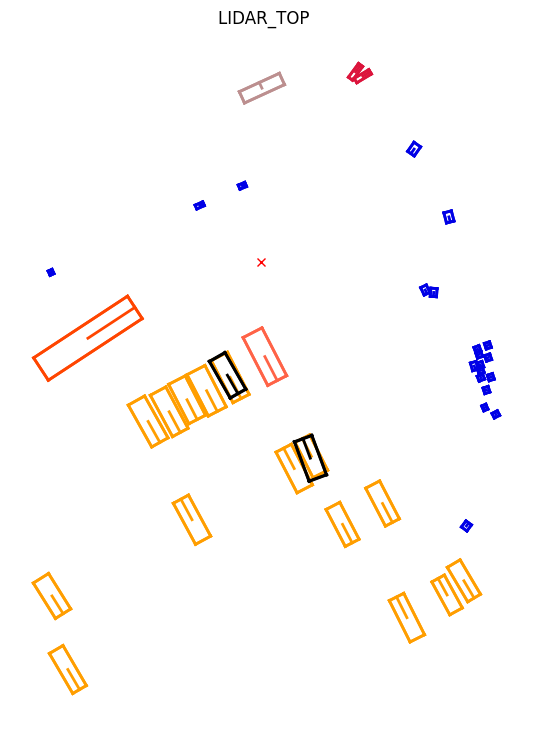

In [93]:
box_list = []
for annotation in nusc_results['results'][sample['token']]:
    box_list.append(Box(center=annotation['translation'], size=annotation['size'], orientation=Quaternion(annotation['rotation'])))
    
# for ann in sample['anns']:
#     details = nusc.get('sample_annotation', ann)
#     box_list.append(Box(center=details['translation'], size = details['size'], orientation=Quaternion(details['rotation'])))
    
render_sample_data_with_predictions(sample['data']['LIDAR_TOP'], underlay_map=False, pred_boxes=box_list)

In [94]:
len(sample['anns'])
for ann in sample['anns']:
    details = nusc.get('sample_annotation', ann)
    print(f"translation = {details['translation']}, \t size = {details['size']} \t class = {details['category_name']}")

translation = [695.325, 1800.564, 0.665], 	 size = [1.862, 4.923, 1.588] 	 class = vehicle.car
translation = [683.188, 1784.527, 0.034], 	 size = [1.743, 4.98, 1.689] 	 class = vehicle.car
translation = [702.876, 1809.858, 0.826], 	 size = [1.955, 5.104, 1.645] 	 class = vehicle.car
translation = [707.223, 1782.619, 0.876], 	 size = [0.583, 0.485, 1.68] 	 class = human.pedestrian.adult
translation = [695.915, 1817.062, 1.283], 	 size = [2.011, 5.159, 1.979] 	 class = vehicle.car
translation = [694.29, 1790.396, 0.262], 	 size = [1.694, 4.594, 1.489] 	 class = vehicle.car
translation = [710.538, 1782.886, 0.848], 	 size = [0.636, 0.58, 1.697] 	 class = human.pedestrian.adult
translation = [667.887, 1818.105, 1.613], 	 size = [1.696, 4.983, 1.604] 	 class = vehicle.car
translation = [738.181, 1805.834, 0.944], 	 size = [0.55, 1.833, 1.21] 	 class = vehicle.bicycle
translation = [712.545, 1784.764, 0.867], 	 size = [0.636, 0.58, 1.281] 	 class = human.pedestrian.adult
translation = [733.7

In [95]:
for annotation in nusc_results['results'][sample['token']]:
    print(f"translation = {annotation['translation']}, \t size = {annotation['size']} \t class = {annotation['detection_name']}")

translation = [703.0201400449228, 1810.191447729472, 0.1210787268399112], 	 size = [1.9279941320419312, 4.523632526397705, 1.6776583194732666] 	 class = car
translation = [696.8569889277663, 1799.1805842223257, -0.15130447936343241], 	 size = [1.9933338165283203, 4.518181324005127, 1.7094485759735107] 	 class = car


In [96]:
# for annotation in nusc_results['results'][sample['token']]:
#     plot_custom_bounding_boxes(sample['token'], [Box(annotation['translation'], annotation['size'], Quaternion(annotation['rotation']), name=annotation['detection_name'])])